# Bulk crystal iprPy calculation combination notebook

In [1]:
# Standard Python packages
import os
from pathlib import Path

# Test if this is a colab environment
iscolab = 'COLAB_RELEASE_TAG' in os.environ

# Install LAMMPS and atomman in colab if needed
if iscolab and not Path('lmp').exists():
    
    if not Path('run').exists():
        Path('run').mkdir()
    
    print('Installing LAMMPS - please wait...')
    !wget https://github.com/lmhale99/atomman-demo/raw/main/lmp.gz
    !gunzip lmp.gz
    !chmod 755 lmp
    
    print('Installing iprPy')
    !pip install iprPy

    print('!!!!! RESTART KERNEL/RUNTIME BEFORE CONTINUING!!!!!')
    
# Import installed packages
else:

    # Standard library imports
    import datetime
    from math import floor

    import tqdm
    
    # http://www.numpy.org/
    import numpy as np

    # https://ipython.org/
    from IPython.display import display, Markdown, Image

    # https://github.com/usnistgov/atomman 
    import atomman as am
    import atomman.lammps as lmp
    import atomman.unitconvert as uc

    # https://github.com/usnistgov/iprPy
    import iprPy

    import pandas as pd
    
    import matplotlib.pyplot as plt

    print('Notebook last executed on', datetime.date.today(), 'using iprPy version', iprPy.__version__)

Notebook last executed on 2023-08-07 using iprPy version 0.11.6


## 1. Basic inputs

LAMMPS executable

In [2]:
if iscolab:
    lammps_command = '/content/lmp'
    
else:
    lammps_command = 'lmp'
    
# Test that the lammps executable works and print LAMMPS version
print('Using LAMMPS version', am.lammps.checkversion(lammps_command)['version'])

Using LAMMPS version 15 Sep 2022


Interatomic potential

In [3]:
potential_name = '1999--Mishin-Y--Ni--LAMMPS--ipr1'

potential = am.load_lammps_potential(id=potential_name, getfiles=True)

Crystal structure with initial lattice guess

In [4]:
prototype = 'A1--Cu--fcc'
symbols = 'Ni'

ucell = am.load('prototype', prototype, symbols=symbols)

## 2. Isolated atom 

This computes the potential energy of an isolated atom.  For most potentials, this is zero resulting in the measured potential energy equalling the cohesive energy.  If not zero then 

$$\frac{E_{coh}}{N} = \frac{E_{pot}}{N} - \sum_i \left( \frac{N_i}{N} (E_{iso})_i \right)$$

for each element i.

In [6]:
isolated = iprPy.load_calculation('isolated_atom')
isolated_dict = isolated.calc(lammps_command, potential)
print(isolated_dict)

{'energy': {'Ni': -3.0970029925997e-11}}


In [7]:
# File cleanup
for fglob in ['isolated.dat', 'log.lammps', 'run0.in']:
    for fname in Path.cwd().glob(fglob):
        fname.unlink()

In [8]:
deltaE = 0.0
for atype, symbol in zip(ucell.atypes, ucell.symbols):
    natoms_atype = np.sum(ucell.atoms.atype == atype)
    
    deltaE = isolated_dict['energy'][symbol] * natoms_atype / ucell.natoms

print('Difference in energy between Ecoh and Epot =', deltaE, 'eV/atom')    

Difference in energy between Ecoh and Epot = -3.0970029925997e-11 eV/atom


## 3. Epot vs r (equation of state)

The E_vs_r_scan calculation does a rigid volumetric energy scan of a crystal structure.  This is used to obtain an initial lattice constant guess for structure relaxation in the next step. 

It also provides an approximate equation of state, EOS, for the crystal structure. However, since the scan holds b/a, c/a, and lattice angles fixed the results for non-cubic structures may be inaccurate if you leave the ratios and angles at their "ideal" values.  Better results can be obtained by re-running this calculation using the relaxed structure identified below.

In [5]:
volscan = iprPy.load_calculation('E_vs_r_scan')
volscan_dict = volscan.calc(lammps_command, ucell, potential)
print(volscan_dict.keys())

dict_keys(['r_values', 'a_values', 'Ecoh_values', 'min_cell'])


In [6]:
# File cleanup
for fglob in ['atom.dat', 'run0-*-log.lammps', 'run0.in']:
    for fname in Path.cwd().glob(fglob):
        fname.unlink()

Plot volumetric energy scan

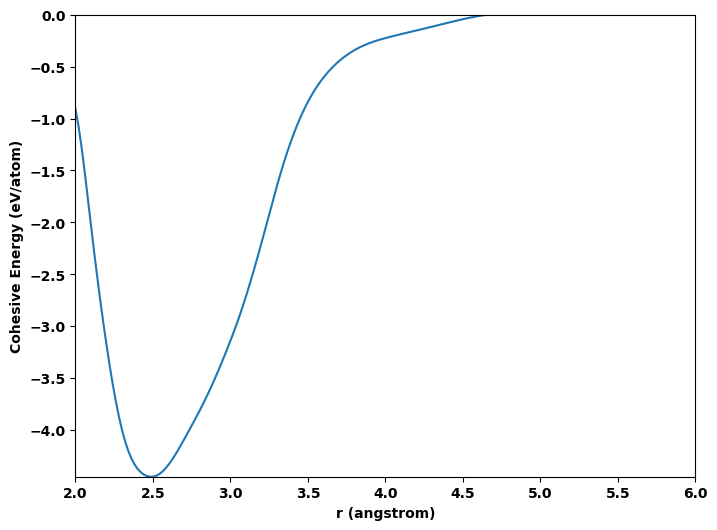

In [7]:
length_unit = 'angstrom'
energy_unit = 'eV'


Epot = uc.get_in_units(volscan_dict['Ecoh_values'], energy_unit)
r = uc.get_in_units(volscan_dict['r_values'], length_unit)


Emin = floor(Epot.min())
if Emin < -10: 
    Emin = -10

fig = plt.figure(figsize=(8,6))
plt.plot(r, Epot)
plt.xlim(r.min(), r.max())
plt.ylim(Epot.min(), 0.0)
plt.xlabel(f'r ({length_unit})')
plt.ylabel(f'Cohesive Energy ({energy_unit}/atom)')

plt.show()

List unit cells close to minimums and select one for further relaxation

In [8]:
for mincell in volscan_dict['min_cell']:
    print('Possible minimum near:')
    print('a =', uc.get_in_units(mincell.box.a, length_unit), length_unit)
    print('b =', uc.get_in_units(mincell.box.b, length_unit), length_unit)
    print('c =', uc.get_in_units(mincell.box.c, length_unit), length_unit)
    print()

Possible minimum near:
a = 3.510660803076929 angstrom
b = 3.510660803076929 angstrom
c = 3.510660803076929 angstrom

Possible minimum near:
a = 7.376651646951118 angstrom
b = 7.376651646951118 angstrom
c = 7.376651646951118 angstrom



In [9]:
ucell = volscan_dict['min_cell'][0]

## 4. Relax crystal

This relaxes a crystal from an initial guess using static minimizations.  

In [25]:
# Load relax_static calculation and run
relax = iprPy.load_calculation('relax_static')
relax_dict = relax.calc(lammps_command, ucell, potential, ftol=1e-08)

# Load final relaxed structure in as the new ucell
ucell = am.load('atom_dump', relax_dict['dumpfile_final'], symbols=relax_dict['symbols_final'])

# Print relaxed structure info
print('E_pot =', relax_dict['E_pot'])
print('a =', ucell.box.a)
print('b =', ucell.box.b)
print('c =', ucell.box.c)
print('alpha =', ucell.box.alpha)
print('beta =', ucell.box.beta)
print('gamma =', ucell.box.gamma)

E_pot = -4.449999998349
a = 3.519999437540423
b = 3.519999437540423
c = 3.519999437540423
alpha = 90.0
beta = 90.0
gamma = 90.0


In [26]:
# File cleanup
for fglob in ['init.dat', 'initial.dump', 'log-*.lammps', 'minbox.in', 'relax_static-*.dump']:
    for fname in Path.cwd().glob(fglob):
        fname.unlink()

## 5. Space group check

Requires spglib to be installed

In [41]:
spg = iprPy.load_calculation('crystal_space_group')
spg_dict = spg.calc(ucell)
print(spg_dict)

{'number': 225, 'international_short': 'Fm-3m', 'international_full': 'F 4/m -3 2/m', 'international': 'F m -3 m', 'schoenflies': 'Oh^5', 'hall_number': 523, 'hall_symbol': '-F 4 2 3', 'choice': '', 'pointgroup_international': 'm-3m', 'pointgroup_schoenflies': 'Oh', 'arithmetic_crystal_class_number': 72, 'arithmetic_crystal_class_symbol': 'm-3mF', 'ucell': <atomman.core.System.System object at 0x000001A1B30D5710>, 'wyckoffs': ['a', 'a', 'a', 'a'], 'equivalent_atoms': array([0, 0, 0, 0], dtype=int32), 'pearson': 'cF4', 'wyckoff_fingerprint': 'a'}


## 6. Elastic constants

In [27]:
# Load calculation and run
elastic = iprPy.load_calculation('elastic_constants_static')
elastic_dict = elastic.calc(lammps_command, ucell, potential, ftol=1e-8)

# Extract results
Cij = elastic_dict['C'].Cij
print('Cij (in GPa) =')
with np.printoptions(precision=2, suppress=True, threshold=5):
    print(uc.get_in_units(Cij, 'GPa'))

Cij (in GPa) =
[[247.86 147.83 147.83   0.     0.     0.  ]
 [147.83 247.86 147.83   0.     0.     0.  ]
 [147.83 147.83 247.86   0.     0.     0.  ]
 [  0.     0.     0.   124.84   0.     0.  ]
 [  0.     0.     0.     0.   124.84   0.  ]
 [  0.     0.     0.     0.     0.   124.84]]


In [28]:
# File cleanup
for fglob in ['init.dat', 'initial.restart', 'log.lammps', 'cij.in']:
    for fname in Path.cwd().glob(fglob):
        fname.unlink()

## 7. Phonons and quasi-harmonic predictions

Requires phonopy to be installed. 

__NOTE__: Extremely memory intensive for unit cells with a large number of atoms!

In [30]:
phonon = iprPy.load_calculation('phonon')
phonon_dict = phonon.calc(lammps_command, ucell, potential, a_mult=3, b_mult=3, c_mult=3)

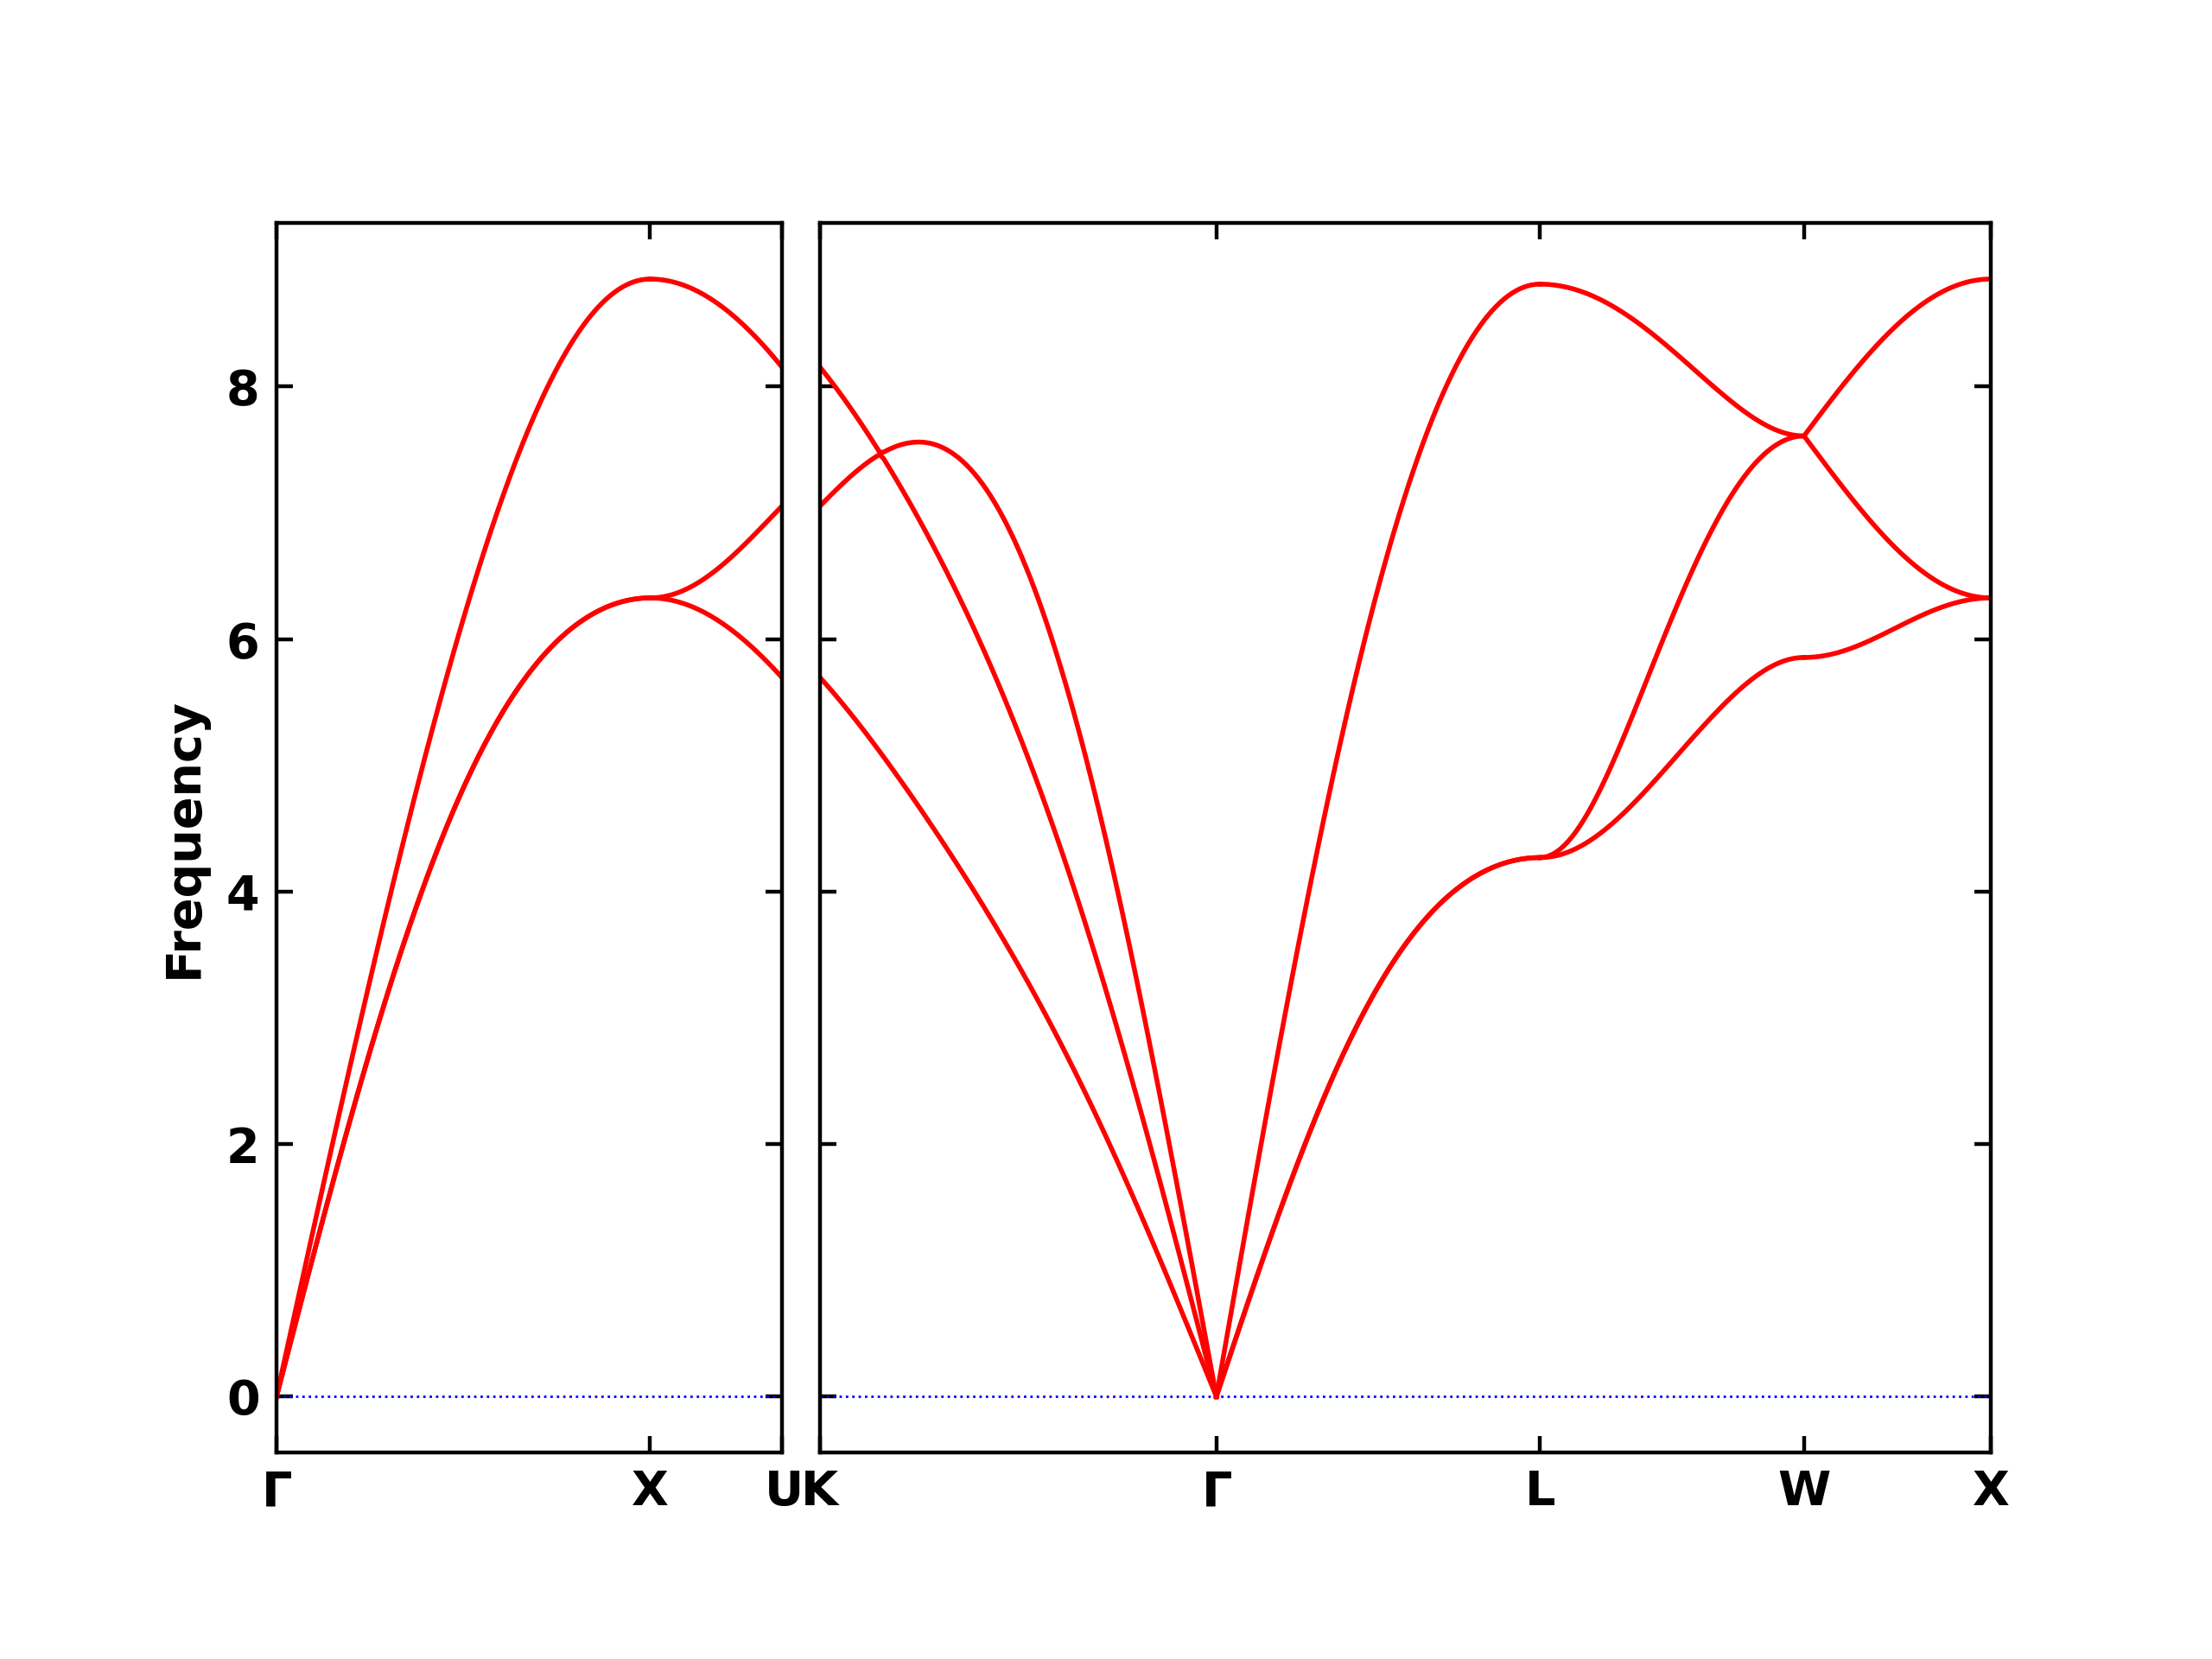

In [33]:
Image("band.png", width=600)

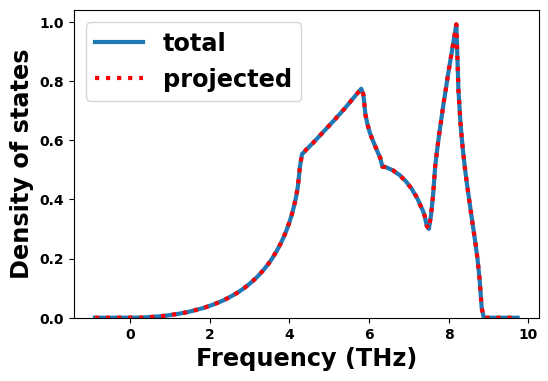

In [39]:
dos = phonon_dict['density_of_states']

fig = plt.figure(figsize=(6,4))

frequency = uc.get_in_units(dos['frequency'], 'THz')
plt.plot(frequency, dos['total_dos'], '-', lw=3, label='total')
for projected in dos['projected_dos']:
    plt.plot(frequency, projected, 'r:', lw=3, label='projected')
plt.xlabel('Frequency (THz)', size='xx-large')
plt.ylabel('Density of states', size='xx-large')
plt.legend(loc=2, fontsize='xx-large')
plt.ylim(0.0, None)
plt.show()

Quasi-harmonic results

In [38]:
thermal = pd.DataFrame(phonon_dict['thermal_properties'])
thermal

,temperature,Helmholtz,entropy,heat_capacity_v,volume,thermal_expansion,Gibbs,bulk_modulus,heat_capacity_p_numerical,heat_capacity_p_polyfit,gruneisen
0,0.0,0.037345,0.000000e+00,0.000000e+00,10.972496,0.000000e+00,-4.412684,1.680766,0.000000e+00,0.000000e+00,0.000000
1,10.0,0.037345,5.636179e-08,1.807752e-07,10.972594,2.532833e-07,-4.412686,1.681856,2.278026e-08,1.848221e-07,25.290111
2,20.0,0.037343,5.291938e-07,1.779477e-06,10.972551,-1.871649e-07,-4.412688,1.681526,1.985767e-06,1.828194e-06,-1.888917
3,30.0,0.037330,2.182263e-06,7.815832e-06,10.972552,7.514049e-07,-4.412700,1.681641,8.400382e-06,8.062332e-06,1.719724
4,40.0,0.037292,6.028758e-06,2.066727e-05,10.972716,2.147259e-06,-4.412739,1.683447,2.097485e-05,2.131353e-05,1.861073
...,...,...,...,...,...,...,...,...,...,...,...
96,960.0,-0.307474,5.808889e-04,2.564408e-04,11.068536,3.847640e-06,-4.760706,4.647222,2.580077e-04,2.557988e-04,0.771588
97,970.0,-0.313296,5.835466e-04,2.564831e-04,11.068958,3.781712e-06,-4.766576,4.684114,2.552550e-04,2.558411e-04,0.764294
98,980.0,-0.319145,5.861774e-04,2.565242e-04,11.069373,3.728147e-06,-4.772472,4.720802,2.588675e-04,2.558803e-04,0.759281
99,990.0,-0.325019,5.887820e-04,2.565641e-04,11.069783,3.674919e-06,-4.778395,4.757681,2.557963e-04,2.559186e-04,0.754202


In [40]:
# File cleanup
for fglob in ['disp.dat', 'forces.dump', 'initial.restart', 'log.lammps', 'phonon.in',
             'phonopy_params_*', 'thermal_properties_*',
              'band.png', 'bulk_modulus.png', 'helmholtz_volume.png']:
    for fname in Path.cwd().glob(fglob):
        fname.unlink()

## 8. Temperature relaxations

At temperature relaxations can also be performed using the relax_dynamic calculation.  It computes the average properties of a relaxed structure as well as the standard error of those properties.

Standard error is the measured standard deviation divided by the square root number of independent (uncorrelated) samples. You can reduce the error by increasing the system size (sizemult value) or by increasing the number of run steps. The error values are large here as this simply serves as a quick demonstration that still takes ~1 min to run each temperature.

**NOTE**: Testing encountered a bug with iprPy 0.11.6 and Python 3.11 with this calculation. For some reason a depreciation warning is being treated as an error.

In [10]:
trelax = iprPy.load_calculation('relax_dynamic')

In [21]:
equilsteps = 20000                  # Number of initial run steps to ignore from averaging/std calculation
runsteps = equilsteps + 200000      # Total number of run steps (equilsteps + averaging steps)
dumpsteps = runsteps                # How often to output dump files - This will only do first and last steps
thermosteps = 100                   # How often to sample thermo values - 100 is safe assumption for uncorrelated samples
sizemult = 3

system = ucell.supersize(sizemult, sizemult, sizemult)

trelax_df = []
for temperature in tqdm.tqdm(range(100, 2100, 100)):

    # Run calc at the target temperature
    trelax_dict = trelax.calc(lammps_command, system, potential=potential,
                              temperature = temperature,
                              integrator = 'npt',
                              runsteps = runsteps,
                              thermosteps = 100,
                              dumpsteps = dumpsteps,
                              equilsteps = equilsteps)
    
    # Update system to final config 
    system = am.load('atom_dump', trelax_dict['dumpfile_final'], symbols=trelax_dict['symbols_final'])
    
    # Append results to trelax_df
    trelax_df.append(trelax_dict)
    
    # File cleanup
    for fglob in ['init.dat', '*.dump', 'log.lammps', 'log-*.lammps', 'full_relax.in',
                  'full_relax_restart.in', '*.restart']:
        for fname in Path.cwd().glob(fglob):
            fname.unlink()
    
# Convert trelax_df into a DataFrame
trelax_df = pd.DataFrame(trelax_df)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [23:43<00:00, 71.20s/it]


In [22]:
trelax_df

,dumpfile_initial,symbols_initial,dumpfile_final,symbols_final,nsamples,E_pot,E_pot_std,E_total,E_total_std,lx,...,measured_pzz,measured_pzz_std,measured_pxy,measured_pxy_std,measured_pxz,measured_pxz_std,measured_pyz,measured_pyz_std,temp,temp_std
0,0.dump,"(Ni,)",220000.dump,"(Ni,)",2001,-4.437524,0.001011,-4.424700,0.001434,10.575120,...,1.734320e-05,0.003660,-0.000003,0.002237,-4.543107e-06,0.002303,-1.920030e-06,0.002214,100.138126,8.006262
1,0.dump,"(Ni,)",220000.dump,"(Ni,)",2001,-4.425147,0.001987,-4.399502,0.002839,10.587827,...,5.023443e-06,0.005861,-0.000004,0.003573,-2.914951e-06,0.003506,-3.109664e-06,0.003516,200.255464,15.653619
2,0.dump,"(Ni,)",220000.dump,"(Ni,)",2001,-4.412734,0.002998,-4.374402,0.004244,10.597403,...,2.575682e-05,0.006691,0.000002,0.005034,-8.070183e-06,0.004717,3.984999e-06,0.004523,299.317086,23.954532
3,0.dump,"(Ni,)",220000.dump,"(Ni,)",2001,-4.399896,0.003984,-4.348652,0.005630,10.611157,...,-4.082470e-07,0.006943,-0.000020,0.005748,-1.641964e-05,0.005536,8.202428e-07,0.005491,400.139919,31.224665
4,0.dump,"(Ni,)",220000.dump,"(Ni,)",2001,-4.387433,0.005002,-4.323496,0.007065,10.618644,...,-2.633115e-05,0.008655,0.000023,0.006150,-3.083168e-06,0.005815,1.469275e-05,0.006002,499.255771,39.228332
5,0.dump,"(Ni,)",220000.dump,"(Ni,)",2001,-4.374432,0.006078,-4.297849,0.008735,10.630852,...,3.002157e-05,0.009230,-0.000018,0.006464,-9.903876e-06,0.006877,9.994774e-06,0.006739,598.005524,47.924676
6,0.dump,"(Ni,)",220000.dump,"(Ni,)",2001,-4.361035,0.007156,-4.271249,0.010019,10.647001,...,-4.580771e-05,0.008890,0.000011,0.006806,-2.210088e-05,0.007235,-9.962010e-06,0.006568,701.109564,54.687952
7,0.dump,"(Ni,)",220000.dump,"(Ni,)",2001,-4.347137,0.008478,-4.244507,0.011608,10.655301,...,9.072876e-05,0.012229,-0.000020,0.006861,-2.360957e-06,0.007376,-4.555587e-05,0.007458,801.402216,64.507063
8,0.dump,"(Ni,)",220000.dump,"(Ni,)",2001,-4.333518,0.009438,-4.218044,0.012949,10.672289,...,4.443857e-05,0.009333,-0.000054,0.008359,1.170814e-05,0.007414,-1.089426e-05,0.008362,901.692421,72.550102
9,0.dump,"(Ni,)",220000.dump,"(Ni,)",2001,-4.319747,0.010915,-4.191401,0.014666,10.685762,...,-7.112567e-05,0.010826,-0.000064,0.009120,-2.916193e-05,0.007459,-2.464995e-05,0.008171,1002.207918,77.458889


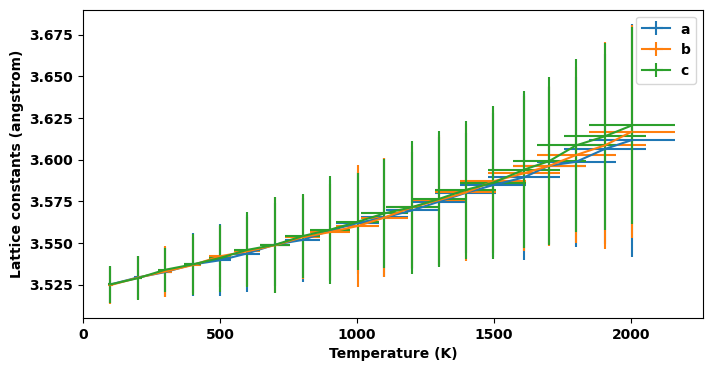

In [23]:
lx = trelax_df.lx  / sizemult
lx_std = trelax_df.lx_std / sizemult
ly = trelax_df.ly  / sizemult
ly_std = trelax_df.ly_std / sizemult
lz = trelax_df.lz  / sizemult
lz_std = trelax_df.lz_std / sizemult


temp = trelax_df.temp
temp_std = trelax_df.temp_std

fig = plt.figure(figsize=(8,4))

plt.errorbar(temp, lx, xerr=temp_std, yerr=lx_std, label='a')
plt.errorbar(temp, ly, xerr=temp_std, yerr=ly_std, label='b')
plt.errorbar(temp, lz, xerr=temp_std, yerr=lz_std, label='c')

plt.xlabel('Temperature (K)')
plt.ylabel('Lattice constants (angstrom)')
plt.xlim(0, None)

plt.legend()
plt.show()